# PyTorch Object Detection and Tracking

## Step 1: Download the object detection system

Download the code to run the object detection

In [1]:
%%shell

# Install pycocotools
git clone https://github.com/cfotache/pytorch_objectdetecttrack

Cloning into 'pytorch_objectdetecttrack'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (36/36), done.


In [2]:
%ls -l
%cd pytorch_objectdetecttrack/
%ls -l

total 8
drwxr-xr-x 6 root root 4096 Oct 18 13:10 pytorch_objectdetecttrack/
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data/
/content/pytorch_objectdetecttrack
total 500
drwxr-xr-x 2 root root   4096 Oct 18 13:10 config/
drwxr-xr-x 2 root root   4096 Oct 18 13:10 images/
-rw-r--r-- 1 root root  14374 Oct 18 13:10 models.py
-rw-r--r-- 1 root root   3735 Oct 18 13:10 object_tracker.py
-rw-r--r-- 1 root root 451724 Oct 18 13:10 PyTorch_Object_Detection.ipynb
-rw-r--r-- 1 root root   5192 Oct 18 13:10 PyTorch_Object_Tracking.ipynb
-rw-r--r-- 1 root root    701 Oct 18 13:10 README.md
-rw-r--r-- 1 root root  10271 Oct 18 13:10 sort.py
drwxr-xr-x 3 root root   4096 Oct 18 13:10 utils/


Download the YoloV3 pretrained weights

In [3]:
%%shell 

ls -l ./config
cd ./config
bash ./download_weights.sh

total 28
-rw-r--r-- 1 root root  115 Oct 18 13:10 coco.data
-rw-r--r-- 1 root root  625 Oct 18 13:10 coco.names
-rw-r--r-- 1 root root   66 Oct 18 13:10 download_weights.sh
-rw-r--r-- 1 root root 8338 Oct 18 13:10 yolov3.cfg
-rw-r--r-- 1 root root 2025 Oct 18 13:10 yolov3-tiny.cfg
--2019-10-18 13:10:13--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   810KB/s    in 1m 56s  

2019-10-18 13:12:10 (2.03 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## Step 2: Apply the object recognition on an image

Necessary imports.

In [0]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

Define the configuration path and initialize Darknet

### Question: Where is Darknet defined? What is it?

---

> Darknet is defined in the config folder (.cfg). 

---

### Question: What is the COCO dataset? What are the labels?

---

> COCO is a large-scale object detection, segmentation, and captioning dataset. There are many labels, including the 'super' category: person, vehicule, outdoor, animal, accessory, sports, kitchen, food, furniture, electronic, appliance, indoor. The full list can be seen below. 
---

In [19]:
config_path='./config/yolov3.cfg'
weights_path='./config/yolov3.weights'
class_path='./config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

#full list 
classes

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

Most of the following code deals with resizing the image to a square while maintaining its aspect ratio and padding the overflow

### Question: What is the goal of the resizing step?

---

> The resize step makes sure the uploaded image'size matches what the model expects and was trained on.  

---

In [0]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    print(image_tensor.shape)
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = image_tensor.type(Tensor)
    
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Print the directory with the image that can be tested.

In [7]:
%ls -l ./images


total 2612
-rw-r--r-- 1 root root   89822 Oct 18 13:10 blueangels-det.jpg
-rw-r--r-- 1 root root  406590 Oct 18 13:10 blueangels.jpg
-rw-r--r-- 1 root root 1993211 Oct 18 13:10 Intersection-Counts.jpg
-rw-r--r-- 1 root root  177753 Oct 18 13:10 olympic-trials.jpg


Load an arbitrary image

In [8]:
%%shell
wget https://upload.wikimedia.org/wikipedia/en/e/e7/Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg

--2019-10-18 13:28:08--  https://upload.wikimedia.org/wikipedia/en/e/e7/Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22960 (22K) [image/jpeg]
Saving to: ‘Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg’

Harry_Potter_and_th 100%[===================>]  22.42K  --.-KB/s    in 0.05s   

2019-10-18 13:28:09 (461 KB/s) - ‘Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg’ saved [22960/22960]



The following cells load an image, get the detections, and then display it with the bounding boxes around detected objects. 

Most of the code deals with scaling and padding the image, as well as getting different colors for each detected class.

In [9]:
# load image and get detections
#img_path = "images/blueangels.jpg"
img_path = "images/Intersection-Counts.jpg"
img_path = "images/olympic-trials.jpg"
img_path = "Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))



torch.Size([3, 415, 416])
Inference Time: 0:00:00.400831


### Question: describe the content of "detections"

---

> Detections contains the coordinates of each bounding boxes that were detected (first 4 values) as well as the predicted class (last value) for each bounding box. Below, we learn that we we can expect 3 boxes as we have 3 rows, all detecting humans as all last values are 0, the index of 'person' in classes.
---

In [10]:
print(detections)

tensor([[237.6612,  52.7263, 413.8017, 361.9816,   0.9926,   0.9998,   0.0000],
        [ -1.2259,  77.7332, 143.7608, 339.5888,   0.9776,   1.0000,   0.0000],
        [218.7043, 113.4746, 305.5472, 253.4926,   0.9645,   1.0000,   0.0000]],
       device='cuda:0')


In [11]:
%ls -l

total 528
drwxr-xr-x 2 root root   4096 Oct 18 13:10 config/
-rw-r--r-- 1 root root  22960 Oct 29  2014 Harry_Potter_and_the_Order_of_the_Phoenix_poster.jpg
drwxr-xr-x 2 root root   4096 Oct 18 13:10 images/
-rw-r--r-- 1 root root  14374 Oct 18 13:10 models.py
-rw-r--r-- 1 root root   3735 Oct 18 13:10 object_tracker.py
drwxr-xr-x 2 root root   4096 Oct 18 13:12 __pycache__/
-rw-r--r-- 1 root root 451724 Oct 18 13:10 PyTorch_Object_Detection.ipynb
-rw-r--r-- 1 root root   5192 Oct 18 13:10 PyTorch_Object_Tracking.ipynb
-rw-r--r-- 1 root root    701 Oct 18 13:10 README.md
-rw-r--r-- 1 root root  10271 Oct 18 13:10 sort.py
drwxr-xr-x 3 root root   4096 Oct 18 13:10 utils/


<Figure size 432x288 with 0 Axes>

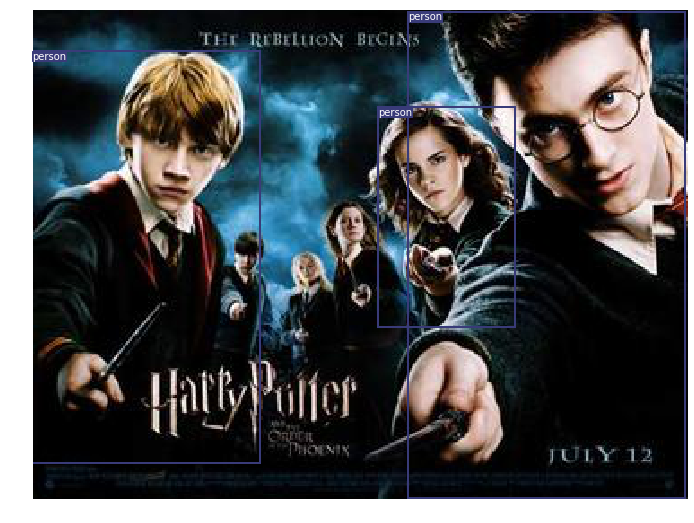

In [12]:
# Get bounding-box colors
cmap = plt.get_cmap('tab20b') # get a colormap
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
plt.show();

### Question: Test an image you will choose yourself

In [25]:
# I chose an image that includes dogs and humans, and many of them.  
%%shell
wget https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/-EXPO_BERGER_10_10_2004_048_%288054969288%29.jpg/1920px--EXPO_BERGER_10_10_2004_048_%288054969288%29.jpg

--2019-10-18 13:48:34--  https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/-EXPO_BERGER_10_10_2004_048_%288054969288%29.jpg/1920px--EXPO_BERGER_10_10_2004_048_%288054969288%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927547 (906K) [image/jpeg]
Saving to: ‘1920px--EXPO_BERGER_10_10_2004_048_(8054969288).jpg.1’

1920px--EXPO_BERGER 100%[===================>] 905.81K  3.14MB/s    in 0.3s    

2019-10-18 13:48:34 (3.14 MB/s) - ‘1920px--EXPO_BERGER_10_10_2004_048_(8054969288).jpg.1’ saved [927547/927547]



In [21]:
# load image and get detections
img_path = "1920px--EXPO_BERGER_10_10_2004_048_(8054969288).jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

torch.Size([3, 415, 416])
Inference Time: 0:00:00.177636


<Figure size 432x288 with 0 Axes>

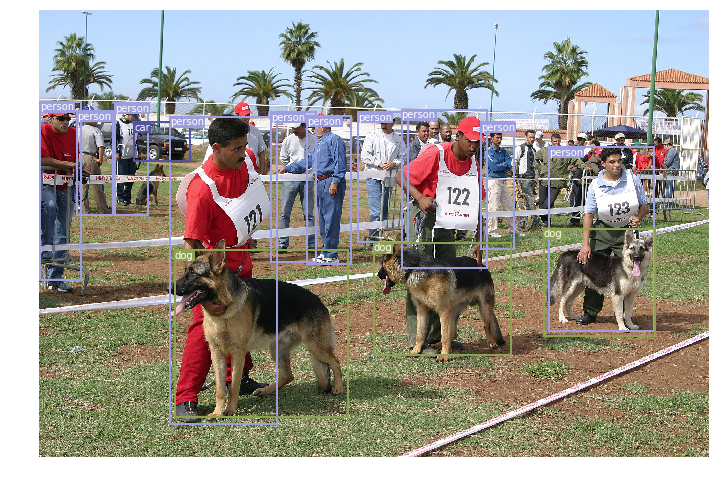

In [22]:
# Get bounding-box colors
cmap = plt.get_cmap('tab20b') # get a colormap
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
plt.show();

In [23]:
print(detections)

tensor([[166.3978, 134.7812, 193.6684, 226.2560,   0.9968,   0.9999,   0.0000],
        [197.7560, 132.0328, 228.6440, 212.4753,   0.9909,   0.9996,   0.0000],
        [143.9182, 131.9654, 171.7873, 225.1814,   0.9657,   0.9999,   0.0000],
        [224.8673, 130.6877, 277.8391, 228.9899,   0.9275,   0.9995,   0.0000],
        [ 23.2777, 131.5212,  45.5047, 195.9493,   0.9243,   0.9998,   0.0000],
        [  0.4192, 125.6817,  25.4928, 236.5635,   0.9003,   0.9995,   0.0000],
        [316.5818, 153.7737, 381.4437, 267.9087,   0.8840,   0.9927,   0.0000],
        [274.4275, 138.5077, 294.7344, 216.8412,   0.8818,   0.9998,   0.0000],
        [ 46.8661, 126.6803,  67.4144, 196.0288,   0.8479,   0.9998,   0.0000],
        [ 81.2034, 134.8276, 147.5435, 325.8441,   0.8460,   0.9996,   0.0000],
        [ 58.7723, 138.2609,  93.7194, 162.5932,   0.9541,   0.9929,   2.0000],
        [ 84.0557, 217.9779, 191.5387, 321.4993,   0.9990,   0.9985,  16.0000],
        [207.4439, 213.1056, 293.0572, 2

---
> Impressive! We can see that it detects mostly persons, as well as 3 dogs (index 16) and 1 car (index 2)
---